Training Data:
| Age     | Weight   | Height   | Gender   | BloodPressureSystolic   | BloodPressureDiastolic   | Cholesterol   | BloodSugar   | SmokingStatus   | AlcoholConsumption   | PhysicalActivity   | AirQuality   | WaterQuality   | FamilyHistory   | DiseaseStatus   | DietQuality_good   | DietQuality_poor   | StressLevel_low   | StressLevel_medium   | SleepQuality_good   | SleepQuality_poor   |
|:--------|:---------|:---------|:---------|:------------------------|:-------------------------|:--------------|:-------------|:----------------|:---------------------|:-------------------|:-------------|:---------------|:----------------|:----------------|:-------------------|:-------------------|:------------------|:---------------------|:--------------------|:--------------------|
| 38.4575 | 65.699   | 143.727  | 1        | 120.301                 | 87.283                   | 236.633       | 85.7029      | 1               | 0                    | 0                  | 29.9181      | 91.

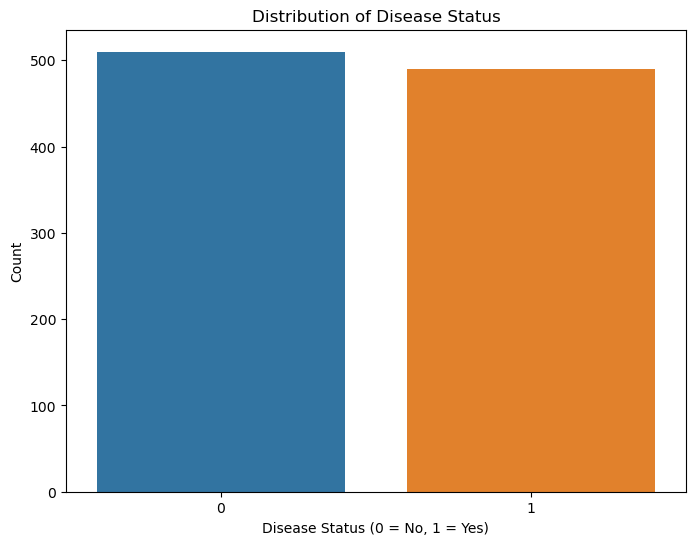

Class distribution:
|    | DiseaseStatus   |
|:---|:----------------|
| 0  | 510             |
| 1  | 490             |


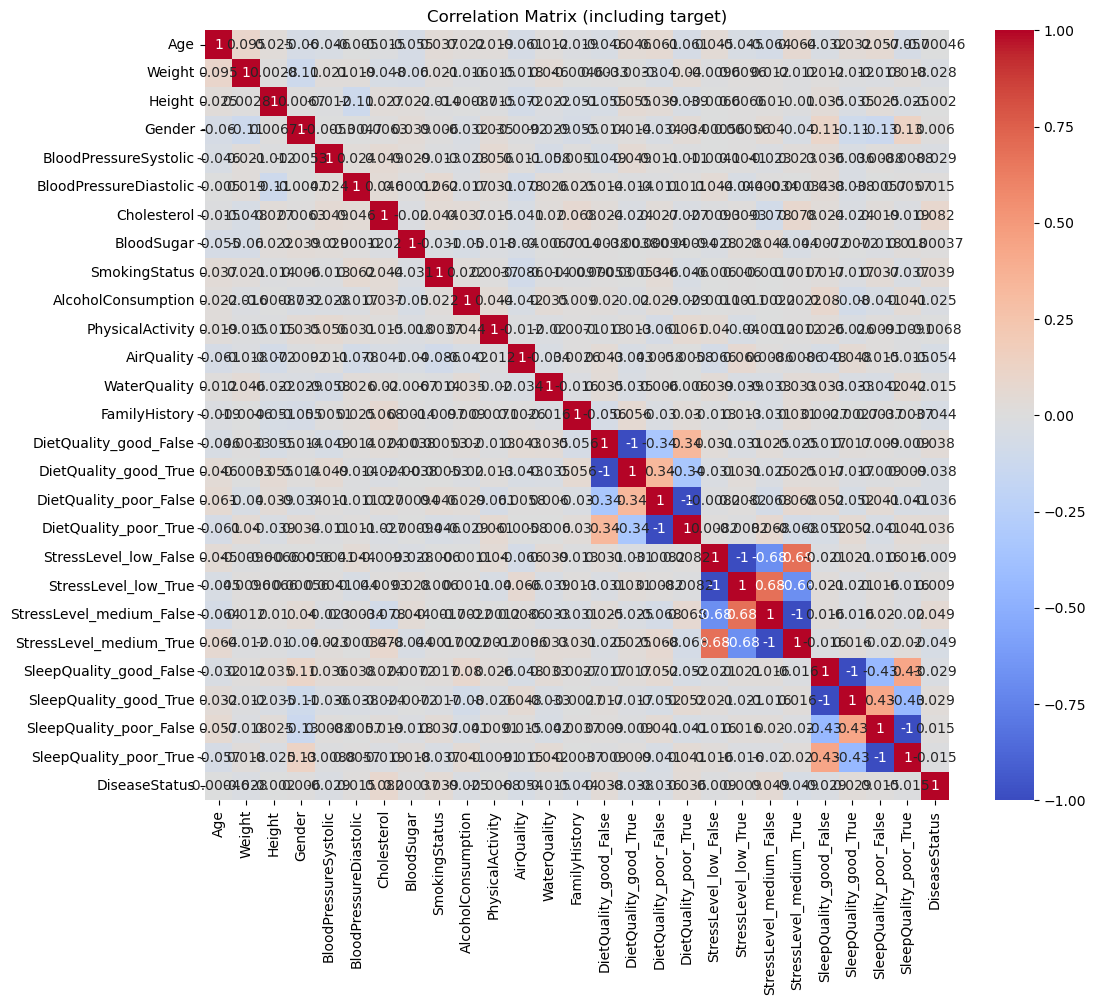

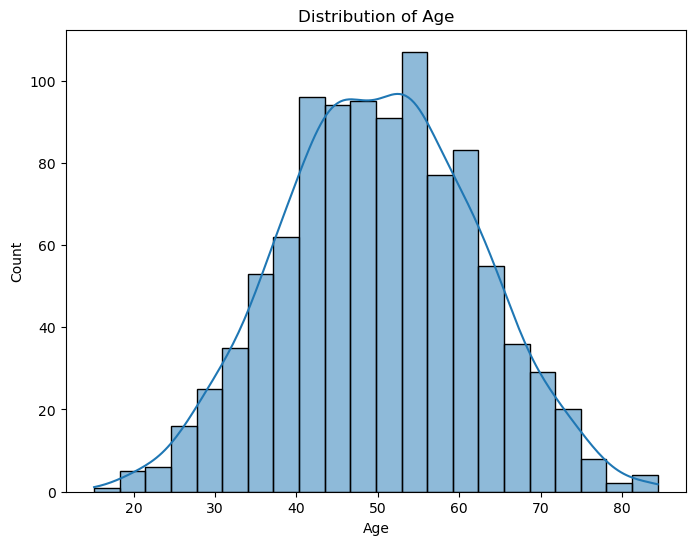

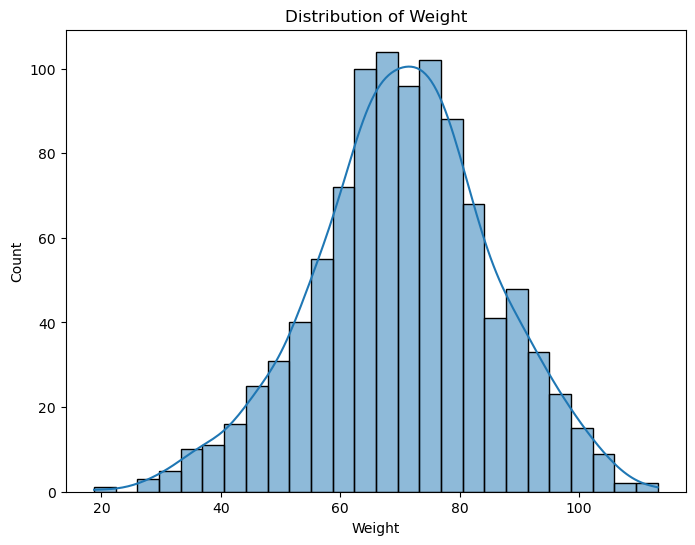

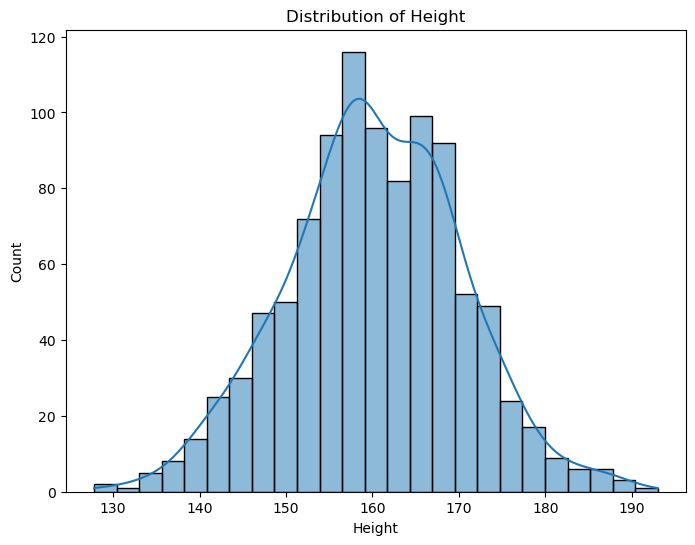

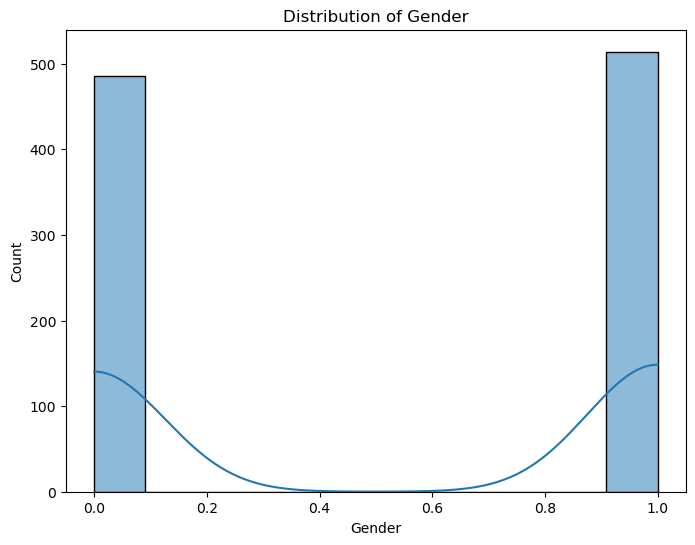

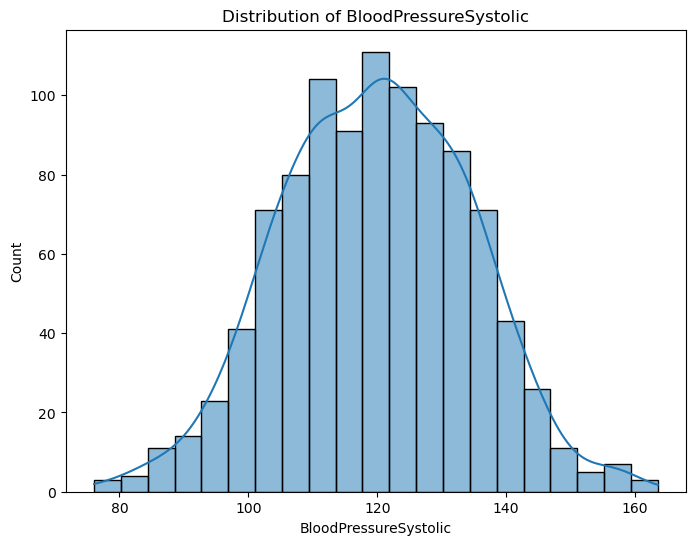

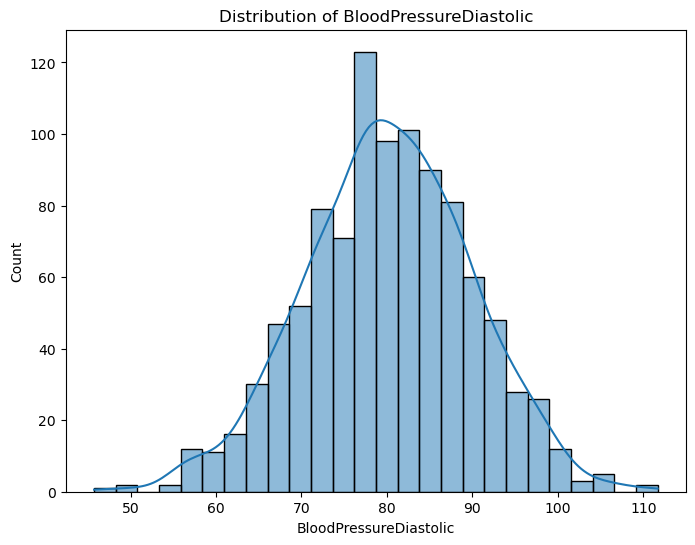

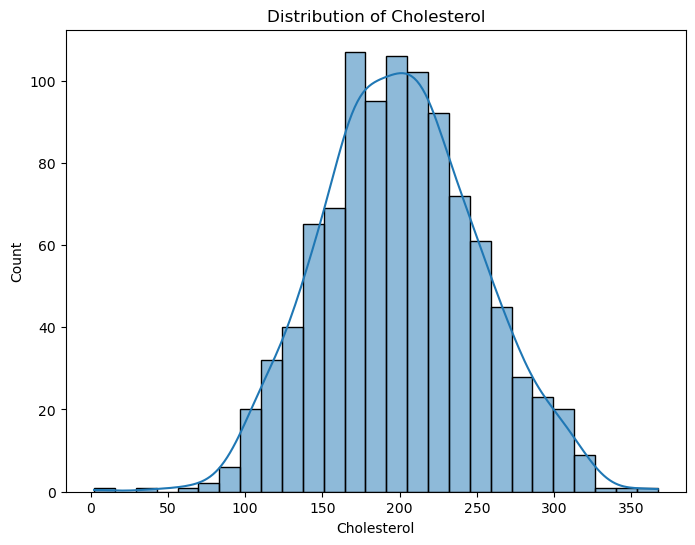

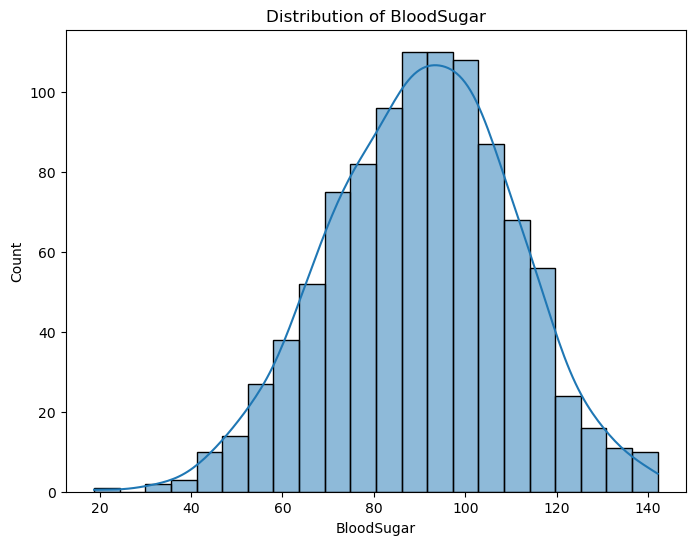

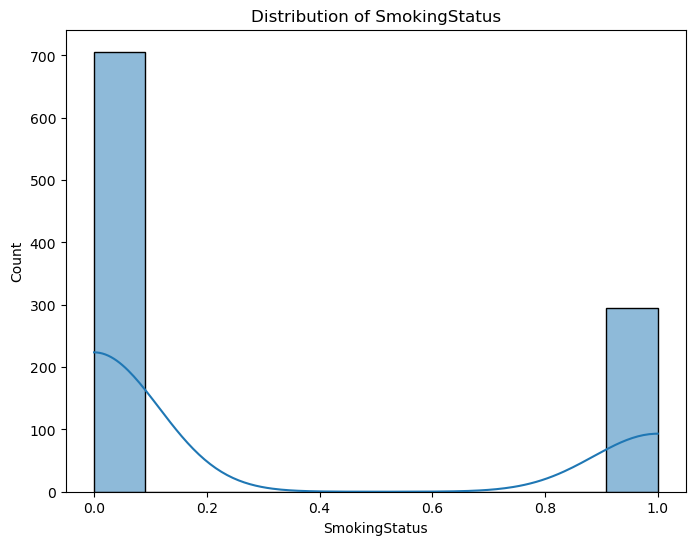

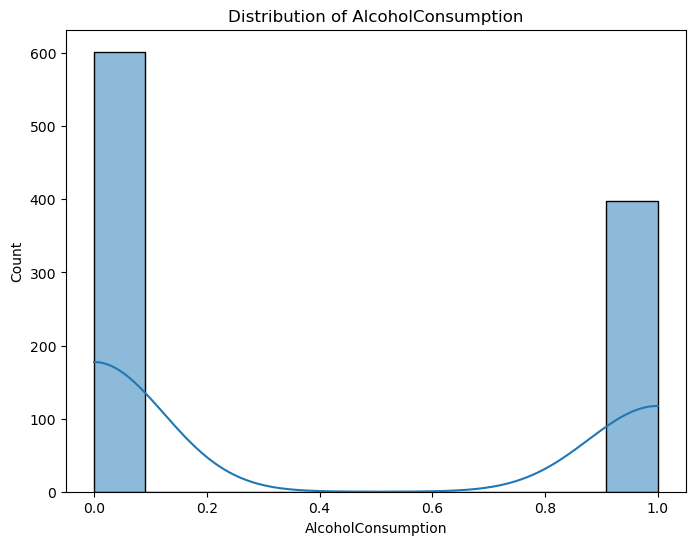

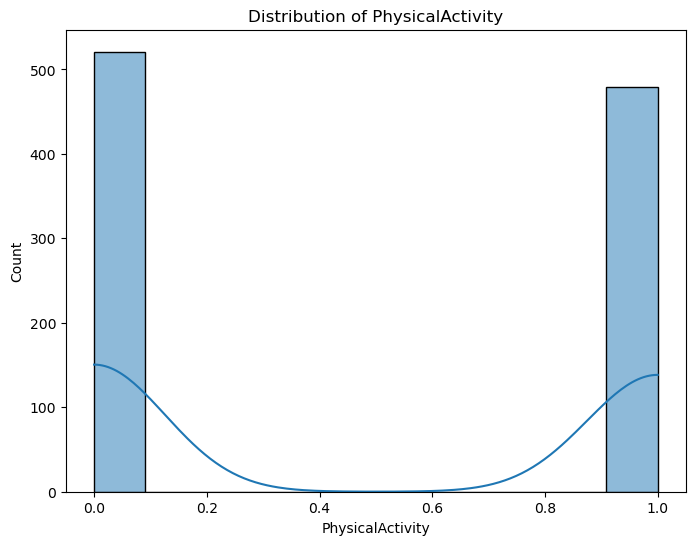

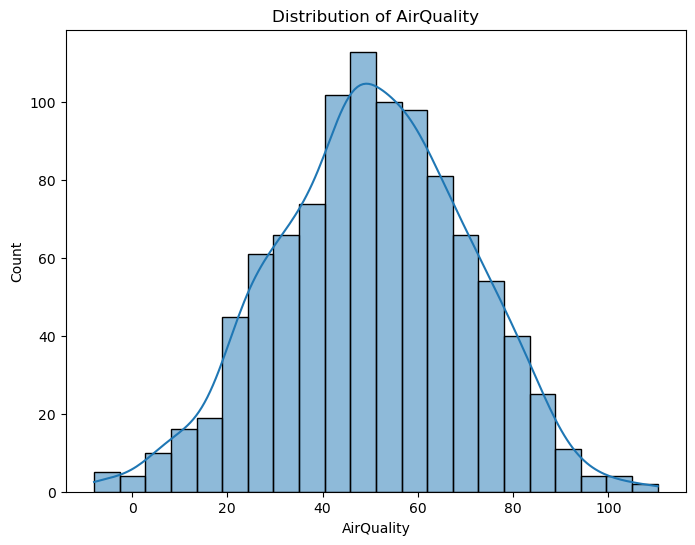

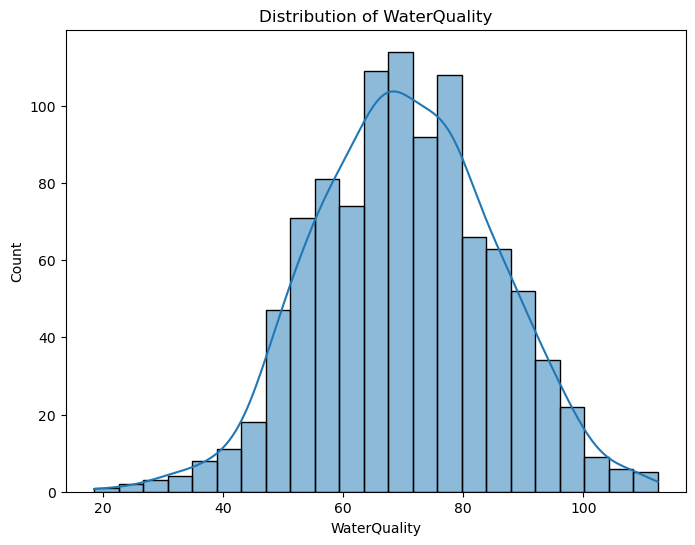

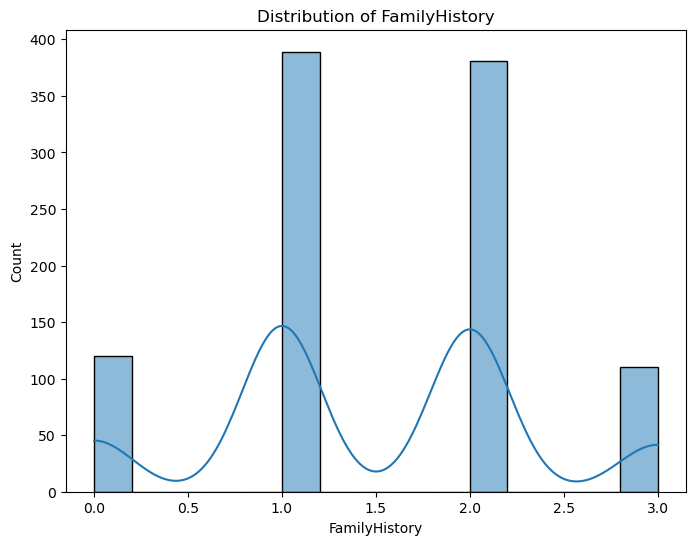

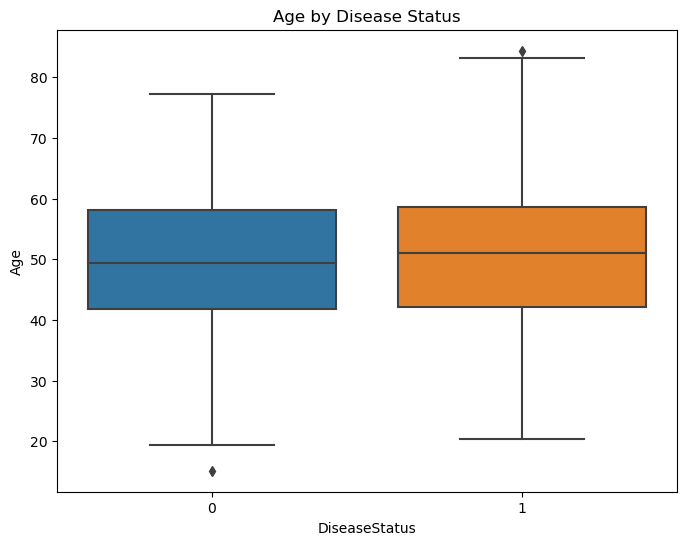

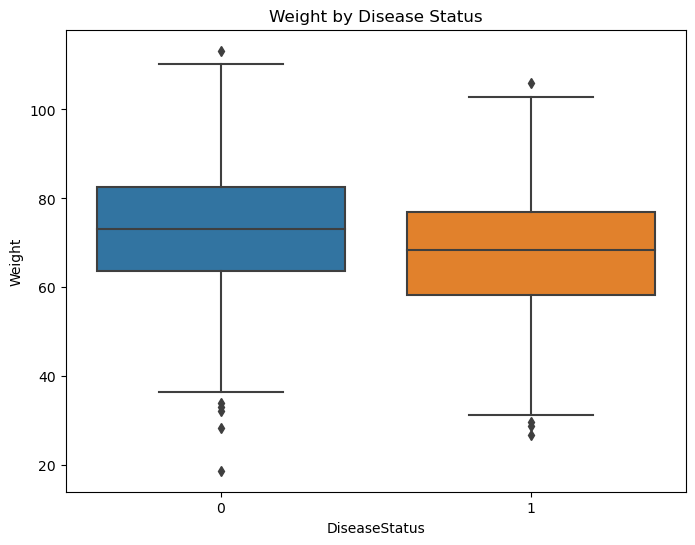

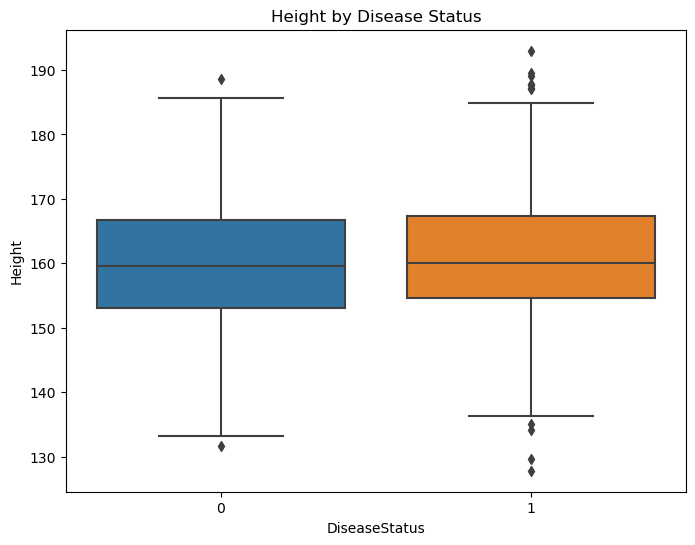

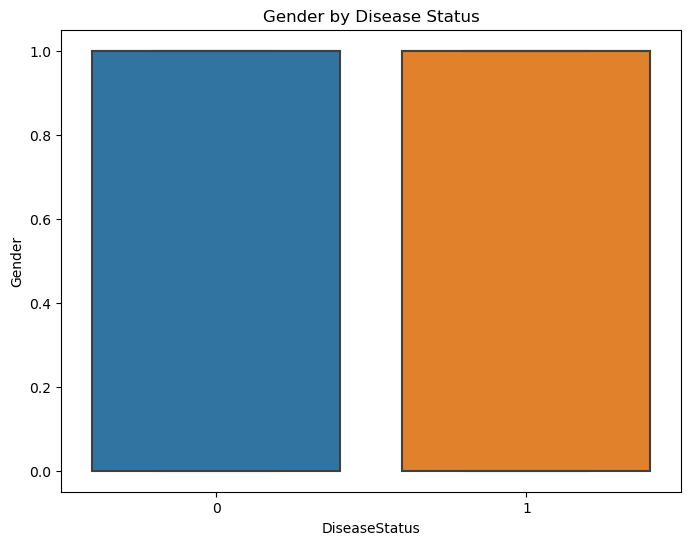

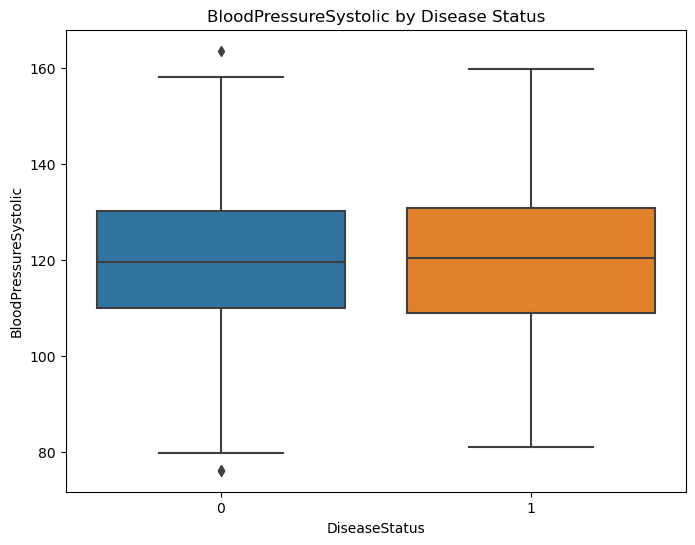

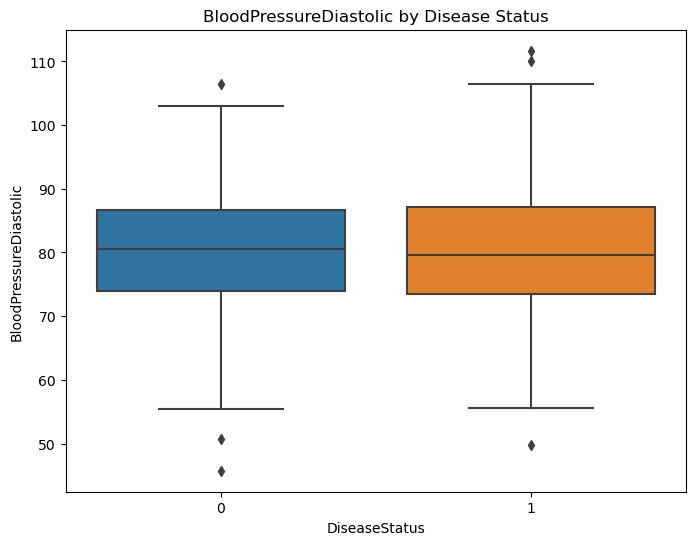

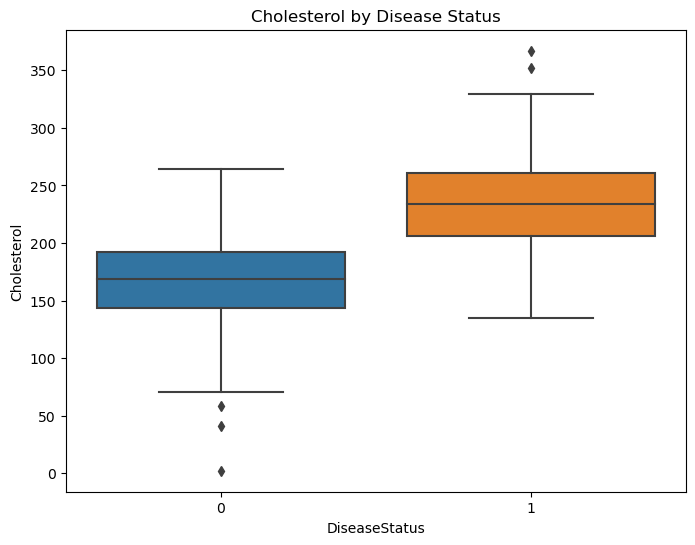

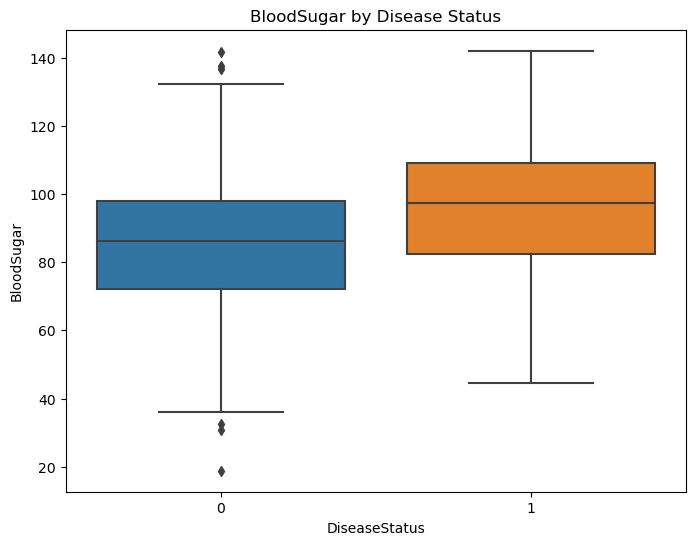

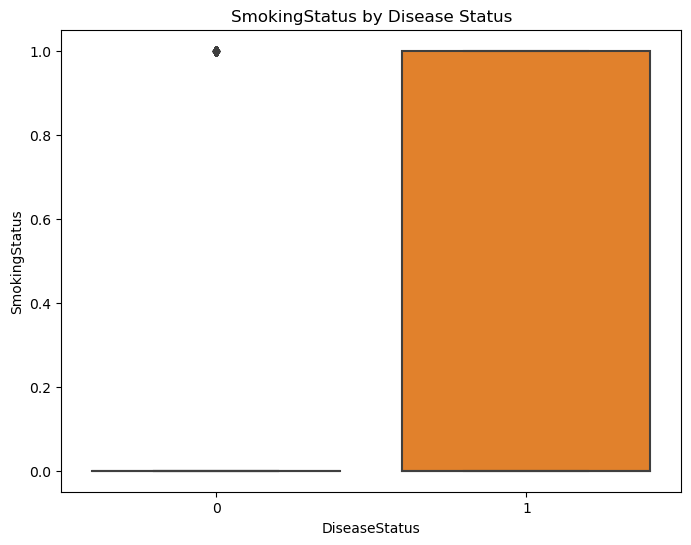

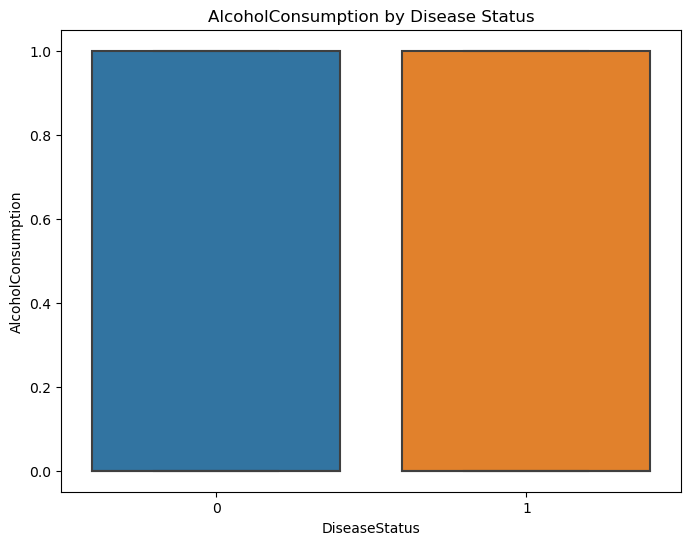

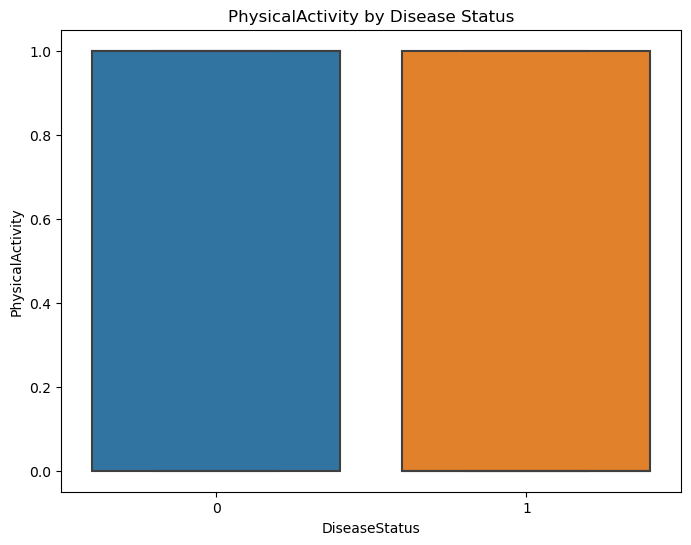

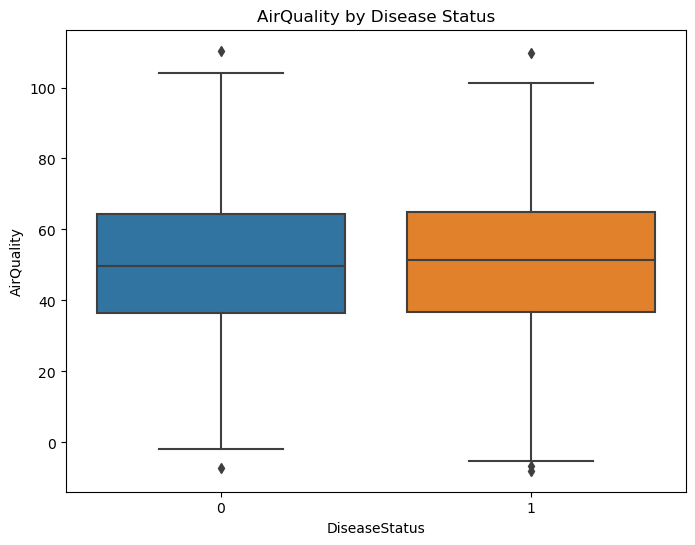

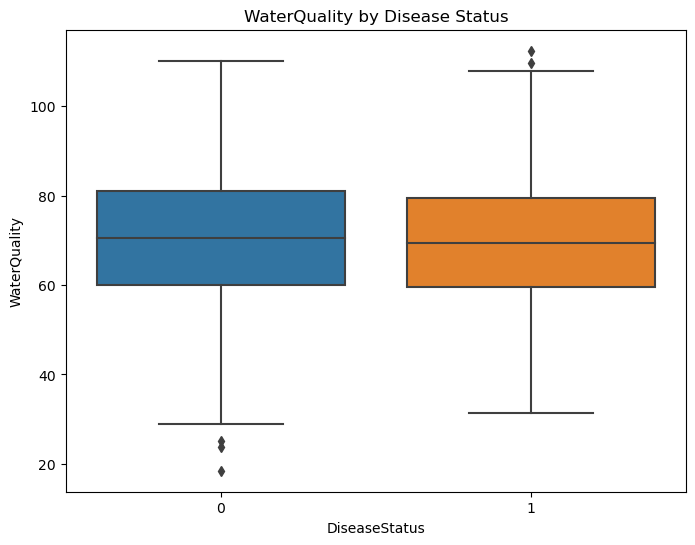

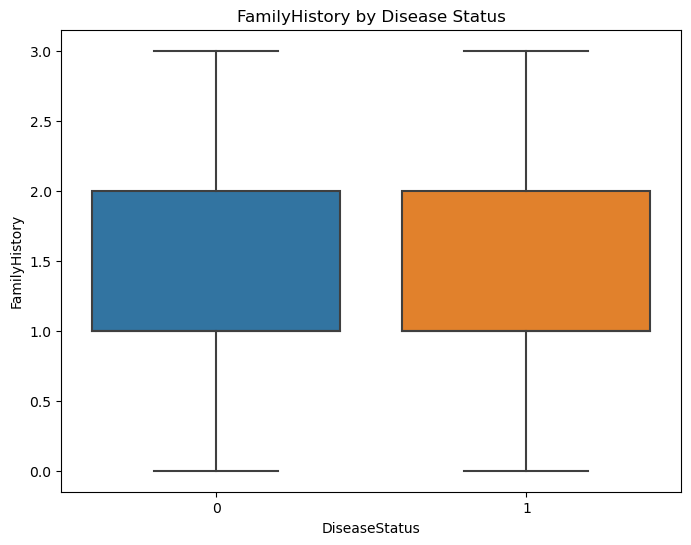


--- Logistic Regression ---
Best Parameters: {'C': 100}
Accuracy (Test): 0.97
AUC-ROC (Test): 0.9982998299829983
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        99
           1       0.97      0.97      0.97       101

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Confusion Matrix:
 [[96  3]
 [ 3 98]]
Coefficients:
Age: 1.567
Weight: -3.237
Height: 0.027
Gender: -0.215
BloodPressureSystolic: -0.290
BloodPressureDiastolic: -0.117
Cholesterol: 14.491
BloodSugar: 6.419
SmokingStatus: 5.887
AlcoholConsumption: -0.092
PhysicalActivity: -1.719
AirQuality: 1.102
WaterQuality: -0.095
FamilyHistory: 0.093
DietQuality_good_False: -0.028
DietQuality_good_True: 0.028
DietQuality_poor_False: -0.185
DietQuality_poor_True: 0.185
StressLevel_low_False: -0.201
StressLevel_low_True: 0.201
StressLevel_medium

<module 'joblib' from 'C:\\Users\\osama\\anaconda3\\Lib\\site-packages\\joblib\\__init__.py'>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import joblib  # For saving the best model

#  Load training data
train_data = pd.read_csv("training_data.csv")

#  Display initial data information
print("Training Data:")
print(train_data.head().to_markdown(index=False, numalign="left", stralign="left"))
print(train_data.info())
print(train_data.describe().to_markdown(numalign="left", stralign="left"))


#  Separate target variable and features
X = train_data.drop(columns="DiseaseStatus")
y = train_data["DiseaseStatus"]

#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Identify numerical and categorical columns (before preprocessing)
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

#  Create preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="mean"), numeric_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

#  Fit the preprocessor and transform the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#  Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  

#  Get the new column names after one-hot encoding
new_column_names = numeric_features + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
)

# Create a DataFrame with column names
X_train_df = pd.DataFrame(X_train, columns=new_column_names)

#  Exploratory Data Analysis (EDA) on the training set
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='DiseaseStatus', data=train_data)
plt.title('Distribution of Disease Status')
plt.xlabel('Disease Status (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Check class imbalance
disease_counts = train_data['DiseaseStatus'].value_counts()
print("Class distribution:")
print(disease_counts.to_markdown(numalign="left", stralign="left"))

# Correlation heatmap (with target variable)
train_data_with_target = pd.concat([X_train_df, y_train], axis=1)  # Combine features and target for correlation
correlation_matrix = train_data_with_target.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (including target)')
plt.show()

# Visualize distribution of numerical features
for col in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Visualize relationship of numerical features with the target
for col in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='DiseaseStatus', y=col, data=train_data)
    plt.title(f'{col} by Disease Status')
    plt.show()

#  Model Selection, Training, and Evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine (SVM)": SVC(probability=True)
}

best_models = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    param_grid = {
        "Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10, 100]},
        "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [None, 5, 10]},
        "Gradient Boosting": {"n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.1, 0.2]},
        "Support Vector Machine (SVM)": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
    }[name]

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")

    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)  # Fit on the entire training data 

    # Predictions and Evaluation on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    print("Accuracy (Test):", accuracy_score(y_test, y_pred))
    print("AUC-ROC (Test):", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # Display coefficients or feature importances
    if name == "Logistic Regression":
        print("Coefficients:")
        for feature, coef in zip(new_column_names, best_model.coef_[0]):
            print(f"{feature}: {coef:.3f}")
    elif name in ["Random Forest", "Gradient Boosting"]:
        print("Top 10 Feature Importances:")
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        for f in range(10):
            print(f"{new_column_names[indices[f]]}: {importances[indices[f]]:.3f}")
    else:  # SVM (or other models)
        print("Coefficients or feature importances not directly interpretable for this model type.")

    best_models[name] = best_model

# Find and save the best model
best_model_name = max(best_models, key=lambda k: roc_auc_score(y_test, best_models[k].predict_proba(X_test)[:, 1]))
print(f"\nBest Model: {best_model_name}")

#  Predict on the test dataset using the best model
best_model = best_models[best_model_name]
test_data = pd.read_csv("test_data_features.csv")
X_test = preprocessor.transform(test_data) # Apply preprocessing to test data
X_test = scaler.transform(X_test)

predictions = best_model.predict(X_test)

# Create a DataFrame with the predictions
output = pd.DataFrame({'DiseaseStatus': predictions})


output.to_csv('challenge_294927.csv', index=False)

print("\nPredictions saved to challenge_294927.csv")

# Save the best model for later use
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib



--- Logistic Regression ---
Best Parameters: {'C': 100}
Accuracy: 0.97
AUC-ROC: 0.9982998299829983
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        99
           1       0.97      0.97      0.97       101

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Confusion Matrix:
 [[96  3]
 [ 3 98]]

--- Random Forest ---
Best Parameters: {'max_depth': None, 'n_estimators': 300}
Accuracy: 0.9
AUC-ROC: 0.9654465446544654
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        99
           1       0.89      0.91      0.90       101

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200

Confusion Matrix:
 [[88 11]
 [ 9 92]]

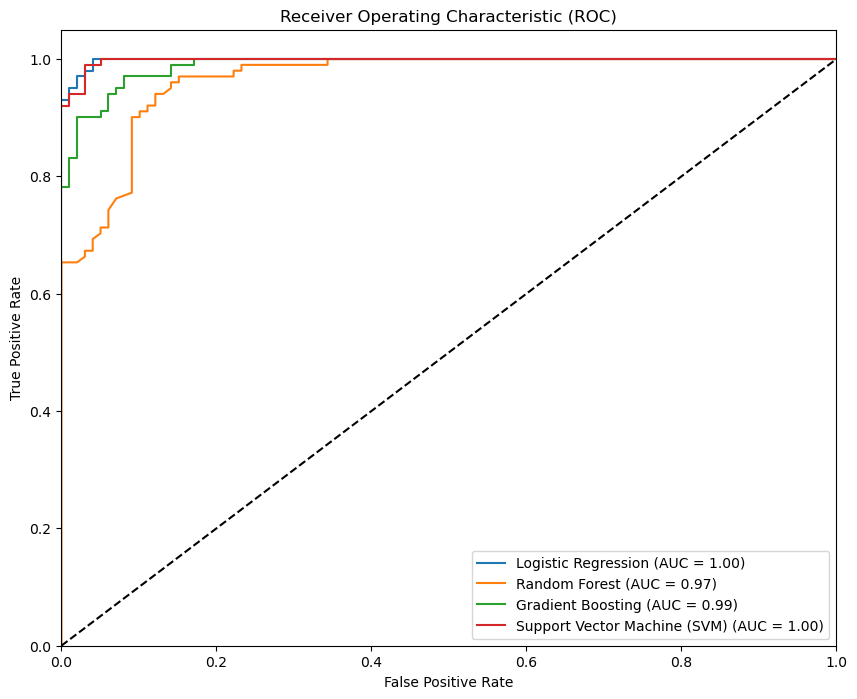

In [17]:
# ... (Model Selection, Training, and Evaluation)

best_models = {}  # Dictionary to store best models

for name, model in models.items():
    print(f"\n--- {name} ---")
    param_grid = {
        "Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10, 100]},
        "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [None, 5, 10]},
        "Gradient Boosting": {"n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.1, 0.2]},
        "Support Vector Machine (SVM)": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
    }[name]

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")

    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    best_models[name] = best_model  # Store the best model


# ROC Curve for all best_models
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 8))
for name, best_model in best_models.items():
    y_prob = best_model.predict_proba(X_test)[:, 1] # Predict probabilities on the test set
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [1]:
import pandas as pd
import joblib

# Load the test data
test_data = pd.read_csv("test_data_features.csv")

# Load the saved model, preprocessor, and scaler
best_model = joblib.load("best_model.pkl")
preprocessor = joblib.load("preprocessor.pkl")
scaler = joblib.load("scaler.pkl")

# Preprocess the test data
X_test = preprocessor.transform(test_data)
X_test = scaler.transform(X_test)

# Make predictions on the test data
predictions = best_model.predict(X_test)

# Create a DataFrame with the predictions
output = pd.DataFrame({"DiseaseStatus": predictions})

# Save the predictions to a CSV file (use index=False to avoid saving row numbers)
output.to_csv("osama_predictions.csv", index=False)

print("\nPredictions saved to final_predictions.csv")



Predictions saved to final_predictions.csv
